<a href="https://colab.research.google.com/github/GURJEW/tasks/blob/main/%D0%A1%D0%BD%D0%B8%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%BD%D0%B5%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача

Представить коллекцию шрифтов в двумерном пространстве.

# Темы


1. Снижение размерности с помощью автокодировшика.
2. Алгоритм снижения размерности [t-SNE](http://datareview.info/article/algoritm-t-sne-illyustrirovannyiy-vvodnyiy-kurs/).
3. Библиотека для работы с интерактивными графиками [Plotly](https://plotly.com/python/).


#Библиотеки

In [ ]:
from google.colab import drive # монтирование диска
import matplotlib.pyplot as plt # графики
import plotly.graph_objs as go # интерактивныйе графики
from plotly.subplots import make_subplots # композиция интерактивных графиков
import pandas as pd # таблицы данных
import numpy as np # массивы данных
import os # система
from PIL import Image, ImageDraw, ImageFont, ImageFilter # изображения
from sklearn.manifold import TSNE # снижение размерности
from IPython.display import clear_output # очистка вывода

from tensorflow.keras.models import Model # модель
from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, Flatten # слои
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, add # слои
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # обрытные вызовы
from tensorflow.keras.optimizers import Adam # оптимизатор

#Константы

In [ ]:
# словарь символов
SYMBOLS = {
    'en': [chr(ord('a')+i) for i in range(26)] + [chr(ord('A')+i) for i in range(26)],
    'ru': [chr(ord('а')+i) for i in range(32)] + [chr(ord('А')+i) for i in range(32)],
    'digits': [str(i) for i in range(10)],
    'marks': ['.', '!', '*', '?', ':', '%', '$', '(', ')', ',', "'", '&', '/', '-', '+', ';', '[', ']', '<', '>', '=']
}

# названия алфавитов
ABC = list(SYMBOLS.keys())

# список символов
CHARS = []
for abc in ABC:
    CHARS += SYMBOLS[abc]

# словарь индексов символов разных типов
INDEXES = {
    'en': range(52),
    'ru': range(52, 116),
    'digits': range(116, 126),
    'marks': range(126, len(CHARS))
}

#Предобработка данных

In [ ]:
drive.mount('/content/gdrive') # мондируем диск
os.chdir('/content/gdrive/My Drive/data') # указываем рабочую директорию

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# создаём датафрейм названий шрифтов и ссылок на них, обходя все вложенные директории
fonts = pd.DataFrame(
    [[file.split('.')[0], f'{top}/{file}'] for top, dirs, files in os.walk('fonts') for file in files],
    columns=['name', 'path']
    ).groupby('name').first().reset_index() # убираем дубликаты шривтов, исходя из их названия
fonts.head()

,name,path
0,AbyssinicaSIL-R,fonts/truetype/abyssinica/AbyssinicaSIL-R.ttf
1,Andale_Mono,fonts/truetype/msttcorefonts/Andale_Mono.ttf
2,AnjaliOldLipi,fonts/truetype/malayalam/AnjaliOldLipi.ttf
3,Arial,fonts/truetype/msttcorefonts/Arial.ttf
4,Arial_Black,fonts/truetype/msttcorefonts/Arial_Black.ttf


In [ ]:
def get_char_array(path, text, size=42):
    try: # если получится
        font = ImageFont.truetype(font=path, size=size) # создаём экземпляр шрифта
        image = Image.new('L', font.getsize(text), color=0) # создаём изображетие нужного размара и цвета
        ImageDraw.Draw(image).text((0, 0), text, fill=255, font=font) # рисуем на нём символ заданным шрифтом
        array = np.array(image.crop(image.getbbox())) # обрезаем изображение по границам символа и конфертируем его в массив
        if not array.ndim: # если массив не масиив
            array = None # так и скажем
    except: # если не получится
        array = None # тоже скрывать не будем
    return array # возвращаем получившийся массив

In [ ]:
def get_abc_array(paths, size=64):
    array = np.zeros((len(paths), size, size, len(CHARS))) # создадём массиив нужной формы
    for c, char in enumerate(CHARS): # для каждого символа
        for p, path in enumerate(paths): # и каждого шрифта
            a = get_char_array(path, char) # создаём массив
            if not a is None: # если это получилось
                h, w = a.shape # определяем высоту и ширину
                i = (size - h) // 2 # определяем индекс нижней границы изображения
                j = (size - w) // 2 # определяем индекс левой границы изображения
                array[p, i:i+h, j:j+w, c] = a # помещаем изображение сивола посередине поля
    return array # возвращаем полученный массив

In [ ]:
all_abc = get_abc_array(fonts.path) # получаем массив алфавитов

In [ ]:
all_abc[..., INDEXES['en']][..., 0].shape

(552, 64, 64)

In [ ]:
all_abc[:10, ...][..., INDEXES['en']].shape

(10, 64, 64, 52)

<p>Иллюстрация массива английского алфавита.</p>
<img src='http://i.imgur.com/CYENE6g.png' alt='массив английского алфавита'>

In [ ]:
data = {} # объявляем словарь для алфавитов
for abc in ABC: # для каждого алфавита
    fonts[abc] = (
        all_abc[..., INDEXES[abc]][..., 0] - all_abc[..., INDEXES[abc]][..., 1]
        ).sum(-1).sum(-1) != 0
    # проверяем существование шрифта (разница матриц двух символов алфавита не должна быть равна нулю)
    data[abc] = all_abc[fonts[abc], ...][..., INDEXES[abc]]
    # получаем матрицы существующих шрифтов каждого алфавита

In [ ]:
# так как это было долго
np.savez_compressed(file='fonts', **data) # сохраняем массивы шрифтов
fonts.to_csv('fonts.csv') # сохраняем описание шрифтов

#Загрузка предобработанных данных

In [ ]:
drive.mount('/content/gdrive') # мондируем диск
os.chdir('/content/gdrive/My Drive/data') # указываем рабочую директорию
data = dict(np.load('fonts.npz')) # загружаем массивы шрифтов
fonts = pd.read_csv('fonts.csv', index_col=0) # загружаем описание шрифтов

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
data.keys()

dict_keys(['en', 'ru', 'digits', 'marks'])

In [ ]:
data['en'].shape

(298, 64, 64, 52)

In [ ]:
fonts.head()

,name,path,en,ru,digits,marks
0,AbyssinicaSIL-R,fonts/truetype/abyssinica/AbyssinicaSIL-R.ttf,True,False,True,True
1,Andale_Mono,fonts/truetype/msttcorefonts/Andale_Mono.ttf,True,True,True,True
2,AnjaliOldLipi,fonts/truetype/malayalam/AnjaliOldLipi.ttf,True,False,True,True
3,Arial,fonts/truetype/msttcorefonts/Arial.ttf,True,True,True,True
4,Arial_Black,fonts/truetype/msttcorefonts/Arial_Black.ttf,True,True,True,True


In [ ]:
def imshow(array):
    plt.imshow(array, cmap='Greys')
    plt.axis('off')
    plt.show()

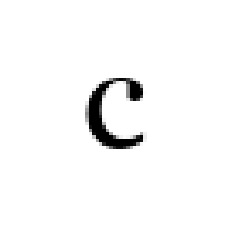

In [ ]:
imshow(data['en'][0, ..., 2])

#Снижение размерности

In [ ]:
def get_x_train(data): # нормализация и размерность данных
    return data / 255, data.shape[0], data.shape[1:]

In [ ]:
x_train, n, shape = get_x_train(data['en']) # получаем данные для обучения

##Стохастическое вложение соседей с t-распределением

In [ ]:
def embedding_to_frame(embedding, abc): # оборачиваем массив вложения во фрейм
    index = fonts.loc[fonts[abc]].index # получаем индексы шрифтов
    columns = ['x', 'y'] # объявляем название колонок фрейма
    return pd.DataFrame(embedding, index, columns) # возвращаем датафрейм вложения

In [ ]:
def embedding_plot(embedding): # рисуем вложение шрифтов в двумерном пространстве
    fig = go.Figure() # объявляем рисунок
    for index in embedding.index: # для каждого индекса шрифтов
        fig.add_trace( # добавляем на рисунок график
            go.Scatter( # в виде точки с координатами
                x=[embedding.x[index]], # X
                y=[embedding.y[index]], # и Y
                mode='markers', # отображаем только сами точки
                name=f'{index}. {fonts.name[index]}' # указываем индекс и название шрифта
                )
            )
    fig.update_layout(margin=dict(l=0, r=100, t=50, b=0)) # добавляем отступы рисунка
    fig.update_traces(hoverinfo='name') # настраиваем интерактивные подписи
    fig.show() # выводим рисунок на печать

In [ ]:
embedding = TSNE().fit_transform(x_train.reshape((n, np.prod(shape)))) # производим вложение объекта в двумерное пространство
embedding_plot(embedding_to_frame(embedding, 'en')) # выводим график вложения

In [ ]:
indexes_first_group = [18, 491, 46, 423, 427, 431, 419] # объявляем игндексы шрифтов первой группы
indexes_second_group = [17, 490, 426, 418, 45, 422, 430] # объявляем игндексы шрифтов второй группы

In [ ]:
def show_fonts(abc, indexes, size=42): # выводим шрифт на печать
    paths = fonts.loc[fonts[abc]].path[indexes] # получаем пути до шрифтов
    names = fonts.loc[fonts[abc]].name[indexes].to_list() # получаем список названий шрифтов
    text = ''.join(SYMBOLS[abc]) # соединяем символы в строку
    fig, ax = plt.subplots(len(indexes), 1, figsize=(16, len(indexes))) # объявляем рисунок для заданного количества шрифтов
    for i, path in enumerate(paths): # для каждого шрифта
        font = ImageFont.truetype(font=path, size=size) # создаём экземпляр
        image = Image.new('L', font.getsize(text), color=0) # создаём изображетие нужного размара и цвета
        ImageDraw.Draw(image).text((0, 0), text, fill=255, font=font) # рисуем текст
        ax[i].imshow(np.array(image), cmap='Greys') # выводим на печать по соответствующей оси
        ax[i].set_title(f'{indexes[i]}. {names[i]}') # подписываем ость
        ax[i].axis('off') # скрываем её отображение
    plt.show() # выводим рисунок на печать

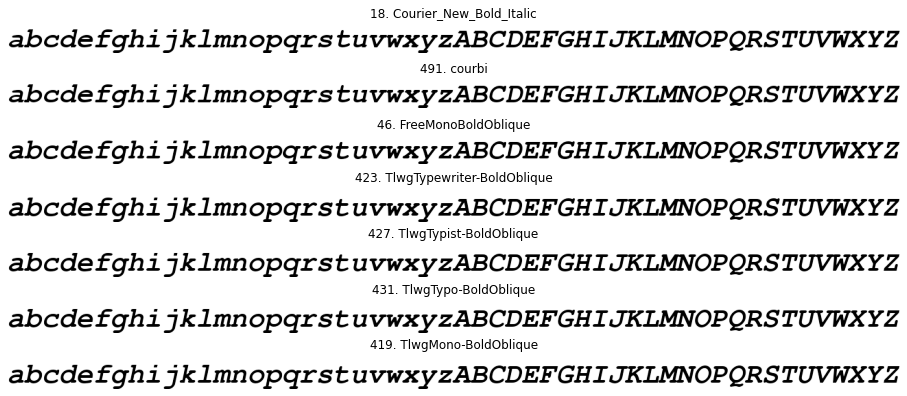

In [ ]:
show_fonts('en', indexes_first_group) # рисуем шрифты первой группы

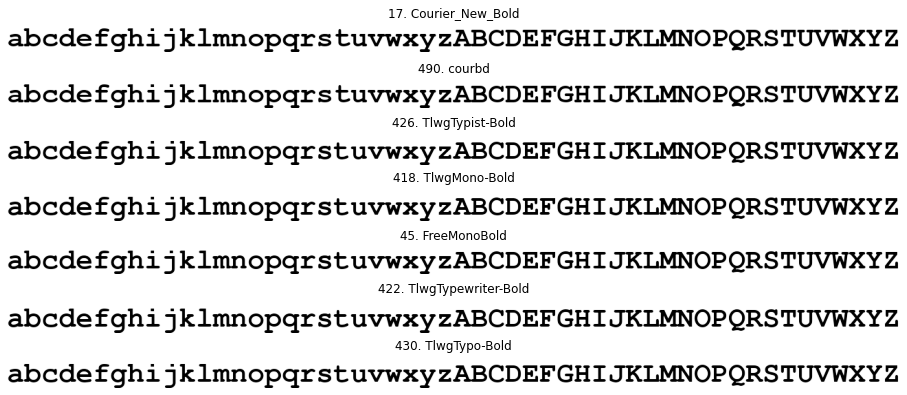

In [ ]:
show_fonts('en', indexes_second_group) # рисуем шрифты второй группы

##Автокодировщики

In [ ]:
def create_model(shape, skip=False): # создаём модель
    inputs = Input(shape) # объявляем вход
    x = inputs # объявляем переменную для слоёв

    for i in range(5): # соединяем 5 свёрточных блоков
        conv = Conv2D(shape[-1], 3, padding='same', activation='relu')(x) # свёрточный слой
        if skip: # если используем skip-connection
            x = add([conv, x]) # добавляем выход предыдущего слоя
        else: # иначе
            x = conv # не добавляем 
        x = MaxPooling2D()(x) # обобщаем соседние признаки ядром 2х2

    x = Flatten()(x) # выпрямляем признаки
    code = Dense(2)(x) # получаем вектор длинной 2 в качестве целевого пространства
    x = Dense(shape[-1] * 4, 'relu')(code) # увеличиваем длину вектора
    x = Reshape((2, 2, shape[-1]))(x) # и возвращаем двумерную форму

    for i in range(5): # соединяем 5
        x = Conv2DTranspose(shape[-1], 3, 2, padding='same', activation='relu')(x) # транспонированных свёрточных слоёв
        
    return Model(inputs, x), Model(inputs, code) # возвращаем автокодировщик и кодировщик

In [ ]:
def history_plot(history): # график истории обучения
    epochs = len(history['loss']) # получаем количество эпох
    history.pop('lr', None) # вырезаем данные о шаге обучения
    fig = make_subplots(rows=1, cols=2) # объявляем рисунок
    for score in history.keys(): # для каждой оценки
        fig.add_trace( # добавляем чертёж на рисунок
            go.Scatter( # в виде точек соединённых линией с координатами
                x=[i + 1 for i in range(epochs)], # эпох по X
                y=history[score], # и значением потерь по Y
                name=score # задаём название графика
                ),
                row=1, # в 1 строке
                col=[1, 2]['mae' in score] # и соответствующем столбце
            ) # 
    fig.update_layout( # настраиваем отображение рисунка
        legend_orientation='h', # местоположение легенды
        margin={'l': 0, 'r': 40, 't': 40, 'b': 0}, # отступы
        title='History' # заголовок
        )
    fig.update_xaxes(title='epochs') # подпись по оси X
    fig.update_yaxes(title='loss (MSE)', row=1, col=1) # подпись по оси Y1 
    fig.update_yaxes(title='MAE', row=1, col=2) # подпись по оси Y2
    fig.update_traces(hoverinfo='all', hovertemplate="epoch: %{x}<br>error: %{y}") # подписи точек
    fig.show() # выводим на печать

In [ ]:
def fit_model(x_train, batch_size=10, learning_rate=0.001, reduce_patience=15, early_patience=20): # обучаем модель
    model.compile( # компилируем
        optimizer=Adam(learning_rate), # оптимизатор
        loss='mse', # функция потерь
        metrics=['mae'] # метрика
    )

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=reduce_patience, verbose=1) # уменьшение шага обучения
    early_stopping = EarlyStopping(restore_best_weights=True, patience=early_patience) # досрочная остановка обучения

    history = model.fit( # записываем историю обучения
        x=x_train, # тренировочные данные
        y=x_train, # тренировочные данные
        batch_size=batch_size, # размер пакета
        epochs=2000, # максимальное количество эпох
        validation_split=0.2, # доля проверочной выборки
        callbacks=[reduce_lr, early_stopping] # список обратных вызовов
    )

    clear_output() # очищаем вывод
    history_plot(history.history) # выводим на печать графики истории обучения 

    prediction = encoder.predict(x_train) # получаем предсказания

    embedding_plot( # выводтм на печать 
        embedding_to_frame( # завернов во фрейм
            prediction, # предсказание
            'en' # шрифтов английского алфавита
            )
        )

    embedding_plot( # выводтм на печать
        embedding_to_frame( # завернов во фрейм
            prediction, # предсказание
            'en' # шрифтов английского алфавита
            ).loc[indexes_first_group + indexes_second_group] # первой и второй группы
        )

In [ ]:
model, encoder = create_model(shape) # создаём модель баз пробросов
fit_model(x_train) # обучаем и выводим на печать результаты

In [ ]:
model, encoder = create_model(shape, True) # создаём модель с пробросами
fit_model(x_train) # обучаем и выводим на печать результаты

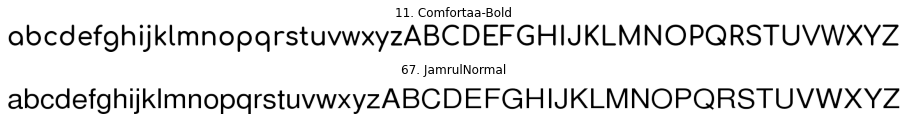

In [ ]:
show_fonts('en', [11, 67])

#EOF